## Importing the Required Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading Images from the Disk

In [2]:
# Global Variables for later use

IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
# function that would read an image provided the image path, preprocess and return it back

def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) # resizing it to 128*128
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [4]:
labels = ['real', 'fake']

X = [] # To store images
y = [] # To store labels

# labels -
# 0 - Real
# 1 - Fake
image_path = './dataset/' # path containing image samples

In [5]:
for folder in os.scandir(image_path):
    for entry in os.scandir(image_path + folder.name):

        X.append(read_and_preprocess(image_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='r':
            y.append(0) # real
        else:
            y.append(1) # fake

In [6]:
X = np.array(X)
X.shape # We have 1289 image samples in total

(1289, 128, 128, 3)

In [7]:
y = np.array(y)
y.shape

(1289,)

## Exploring the Dataset

<BarContainer object of 2 artists>

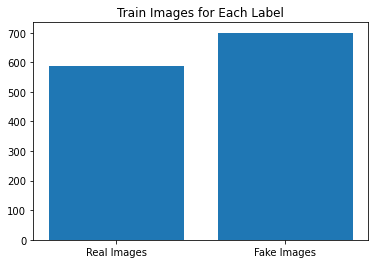

In [8]:
real_count = len(y[y==0])
fake_count = len(y[y==1])

plt.title("Train Images for Each Label")
plt.bar(["Real Images", "Fake Images"],[real_count, fake_count])

# We have more samples of Fake Images than Real Images

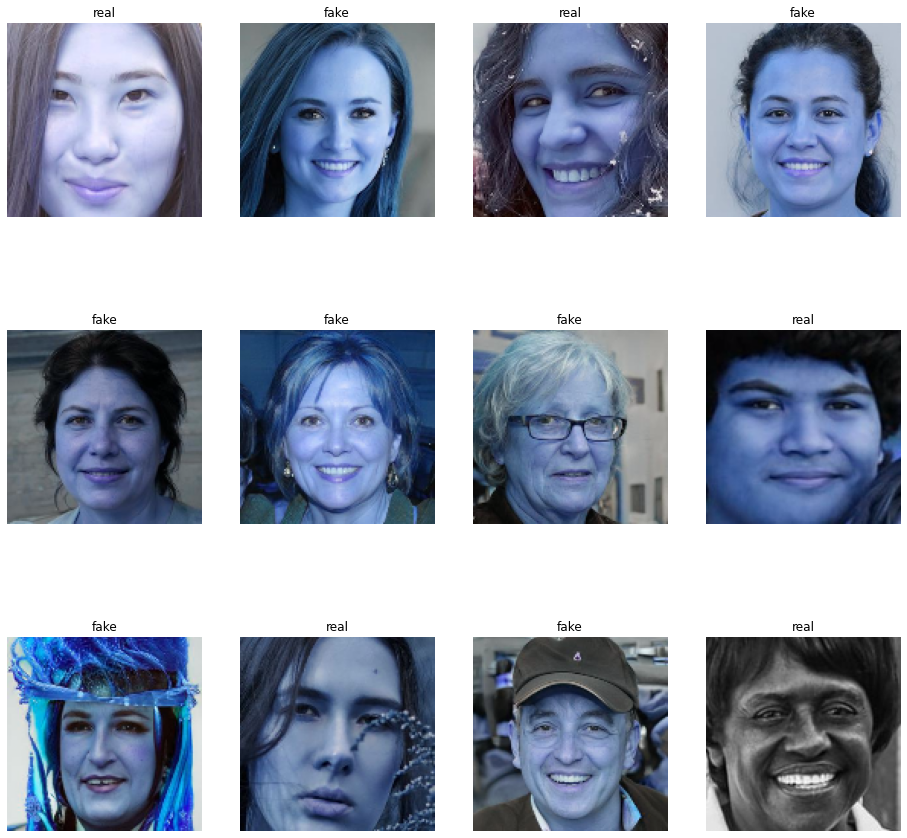

In [9]:
# plotting random images

import random

plt.figure(figsize=(16, 16))

for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.axis("off")
    img = random.randint(0, 1289)
    plt.imshow(X[img])
    plt.title(labels[y[img]])

## Splitting the dataset

We will take -
- 80% data for training our model
- 10% data for validation purpose
- 10% data for test purpose

In [10]:
from sklearn.model_selection import train_test_split

# We have splitted our data in a way that - 
# 1. The samples are shuffled
# 2. The ratio of each class is maintained (stratify)
# 3. We get same samples every time we split our data (random state)

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  shuffle=True, 
                                                  stratify=y, 
                                                  random_state=123)

In [11]:
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, 
                                                  test_size=0.5, 
                                                  shuffle=True, 
                                                  stratify=y_val, 
                                                  random_state=123)

In [12]:
# we are using 1031 images for training our model
X_train.shape

(1031, 128, 128, 3)

In [13]:
# we are using 129 images for validating our model
X_val.shape

(129, 128, 128, 3)

In [14]:
# we are using 129 images for testing our model
X_test.shape

(129, 128, 128, 3)

In [15]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape),
    MaxPooling2D((4,4)),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((3,3)),
    Dropout(0.3), # for regularization
    
    Conv2D(filters=64, kernel_size=(4,4), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    
    Flatten(), # flattening for feeding into ANN
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

In [16]:
# There are 1.1 Million Traininable Parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        6

In [17]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [18]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="fakevsreal_weights.h5", verbose=1, save_best_only=True)

In [19]:
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.5267
Epoch 1: val_loss improved from inf to 0.68685, saving model to fakevsreal_weights.h5
33/33 [==============================] - 6s 49ms/step - loss: 0.6941 - accuracy: 0.5267 - val_loss: 0.6869 - val_accuracy: 0.5426
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6952 - accuracy: 0.5393
Epoch 2: val_loss did not improve from 0.68685
33/33 [==============================] - 1s 24ms/step - loss: 0.6949 - accuracy: 0.5403 - val_loss: 0.6898 - val_accuracy: 0.5426
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6910 - accuracy: 0.5444
Epoch 3: val_loss did not improve from 0.68685
33/33 [==============================] - 1s 23ms/step - loss: 0.6910 - accuracy: 0.5432 - val_loss: 0.6902 - val_accuracy: 0.5426
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6911 - accuracy: 0.5343
Epoch 4: val_loss improved from 0.68685 to 0.68663

31/33 [===========================>..] - ETA: 0s - loss: 0.0143 - accuracy: 0.9970
Epoch 29: val_loss did not improve from 0.03059
33/33 [==============================] - 1s 24ms/step - loss: 0.0143 - accuracy: 0.9971 - val_loss: 0.0646 - val_accuracy: 0.9845
Epoch 30/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0119 - accuracy: 0.9940
Epoch 30: val_loss did not improve from 0.03059
33/33 [==============================] - 1s 24ms/step - loss: 0.0120 - accuracy: 0.9942 - val_loss: 0.0756 - val_accuracy: 0.9845
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0072 - accuracy: 0.9950
Epoch 31: val_loss improved from 0.03059 to 0.01062, saving model to fakevsreal_weights.h5
33/33 [==============================] - 1s 26ms/step - loss: 0.0069 - accuracy: 0.9952 - val_loss: 0.0106 - val_accuracy: 0.9922
Epoch 32/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0118 - accuracy: 0.9990
Epoch 32: val_loss did not improve from 0.01062
33/3

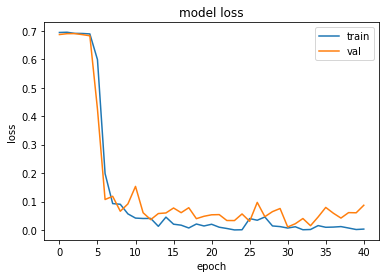

In [20]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

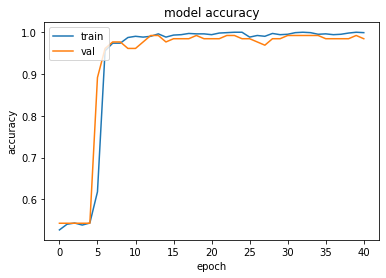

In [21]:
# The is how training accuracy and validation accuracy varied during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("fakevsreal_model.json","w") as json_file:
  json_file.write(model_json)

## Evaluating the Saved Model Performance

In [23]:
# Load pretrained model (best saved one)
with open('fakevsreal_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model weights  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('fakevsreal_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [24]:
# making predictions
predictions = model.predict(X_test)

In [25]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [26]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

1.0

<AxesSubplot:>

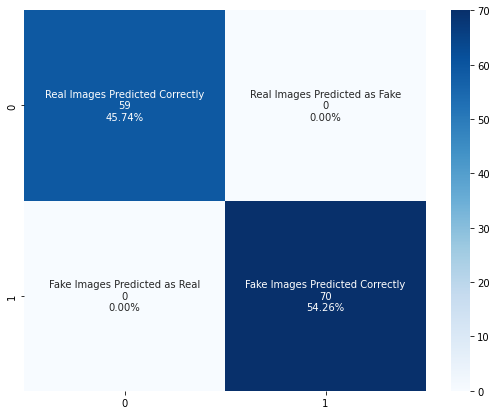

In [27]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, predict)
plt.figure(figsize = (9,7))

group_names = ['Real Images Predicted Correctly','Real Images Predicted as Fake','Fake Images Predicted as Real','Fake Images Predicted Correctly']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [28]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        70

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129

